In [1]:
# Import required libraries
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Import AIDM modules
from visualize_attacks import AttackVisualizer, create_attack_visualizer
from attacks import AttackGenerator
from data_loader import load_sample_data
import yaml

# Configure plotting
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load configuration
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Create visualizer
visualizer = create_attack_visualizer(output_dir='../outputs/reports')

print("Configuration loaded:")
print(f"- Small data mode: {config['compute']['small_data_mode']}")
print(f"- Output path: {config['data']['output_path']}")
print(f"- Attack types: {config['attacks'].keys()}")

Configuration loaded:
- Small data mode: True
- Output path: ./outputs
- Attack types: dict_keys(['fdia', 'temporal_stealth', 'replay', 'art_attacks'])


In [3]:
# Generate sample attack data
generator = AttackGenerator(config)

# Create synthetic measurements first
n_samples = 1000
n_measurements = 12
timestamps = pd.date_range(start='2024-01-01', periods=n_samples, freq='1S')

# Generate base measurements (voltage-like)
base_measurements = np.random.randn(n_samples, n_measurements) * 0.05 + 1.0
base_measurements = np.abs(base_measurements)  # Ensure positive voltages

# Initialize power model with correct dimensions AFTER we know the measurement count
generator.initialize_power_model(n_measurements=n_measurements)

# Generate comprehensive attack dataset
attack_data = generator.generate_attack_dataset(
    measurements=base_measurements,
    timestamps=timestamps,
    attack_types=['fdia', 'temporal_stealth', 'replay'],
    attack_ratio=0.3
)

print(f"Generated attack dataset:")
print(f"- Total samples: {attack_data['metadata']['total_samples']}")
print(f"- Attack samples: {attack_data['metadata']['attack_samples']}")
print(f"- Attack ratio: {attack_data['metadata']['attack_ratio']:.2%}")
print(f"- Attack types: {attack_data['metadata']['attack_types_used']}")

Generated attack dataset:
- Total samples: 1000
- Attack samples: 931.0
- Attack ratio: 93.10%
- Attack types: ['fdia', 'temporal_stealth', 'replay']


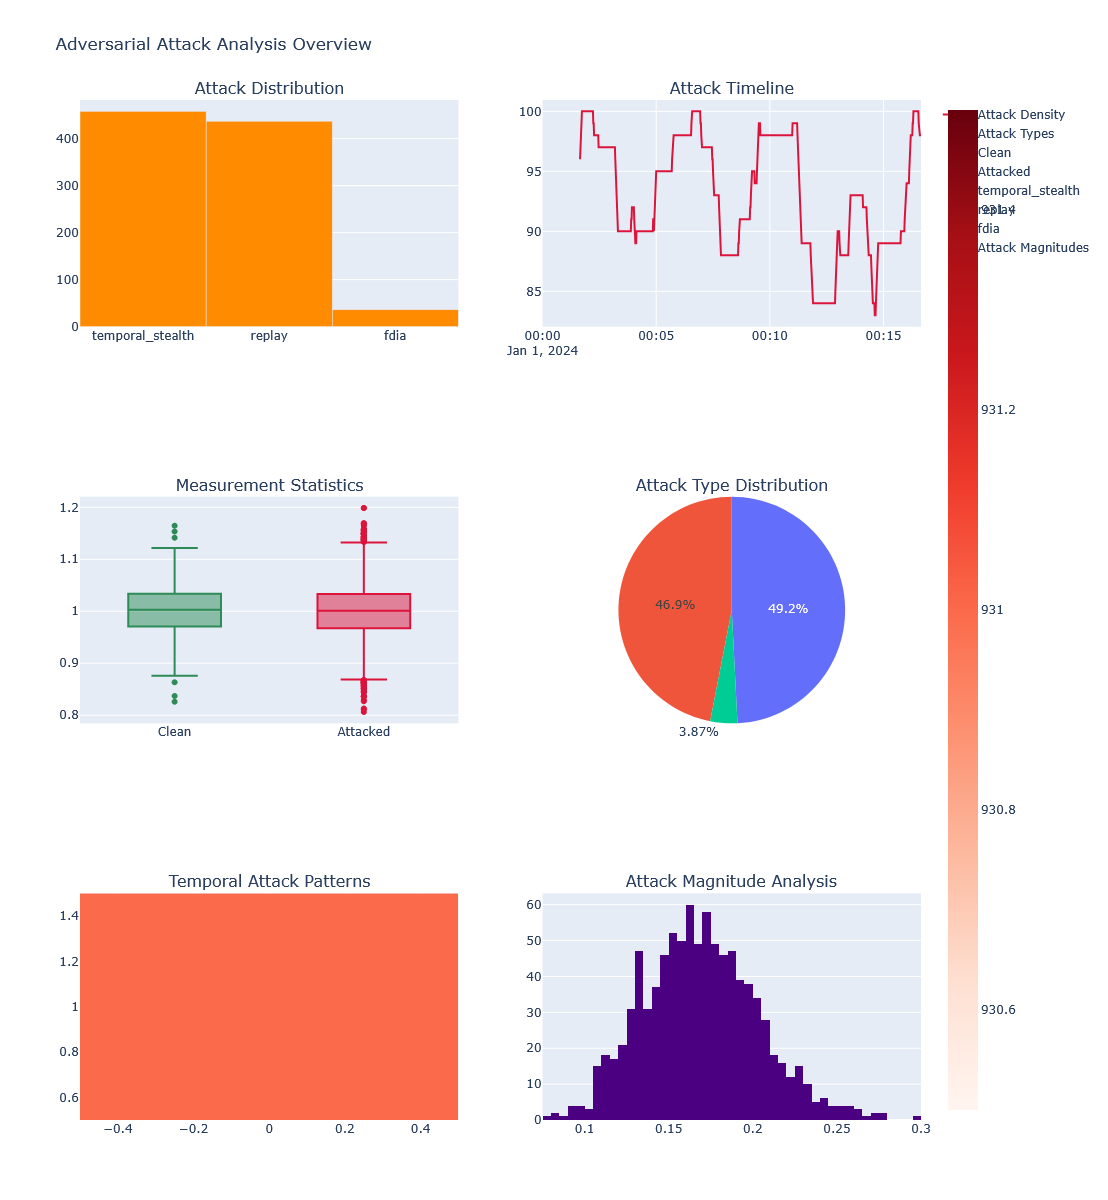

In [4]:
# Create attack overview plot
overview_fig = visualizer.plot_attack_overview(attack_data)
overview_fig.show()

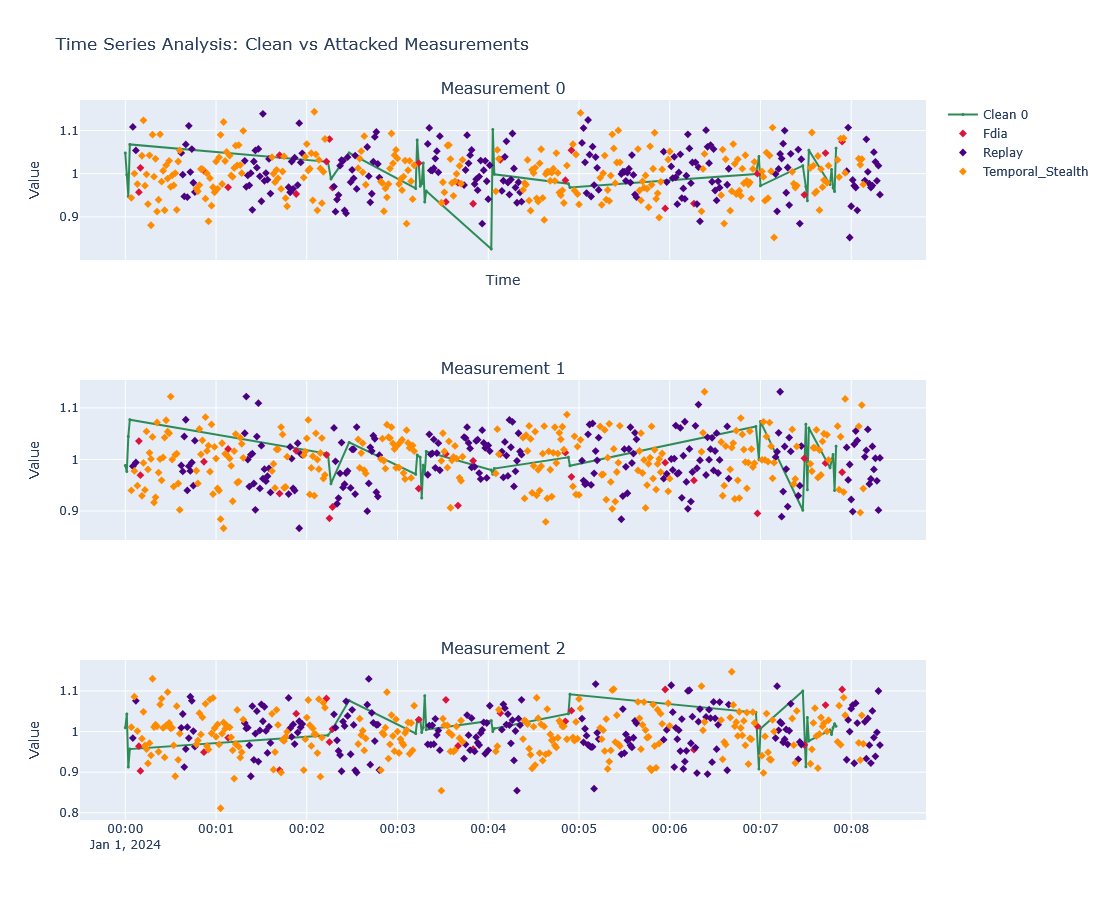

In [5]:
# Plot time series showing attacks
timeseries_fig = visualizer.plot_attack_timeseries(
    attack_data, 
    measurement_indices=[0, 1, 2],  # First 3 measurements
    time_window=(0, 500)  # First 500 samples
)
timeseries_fig.show()

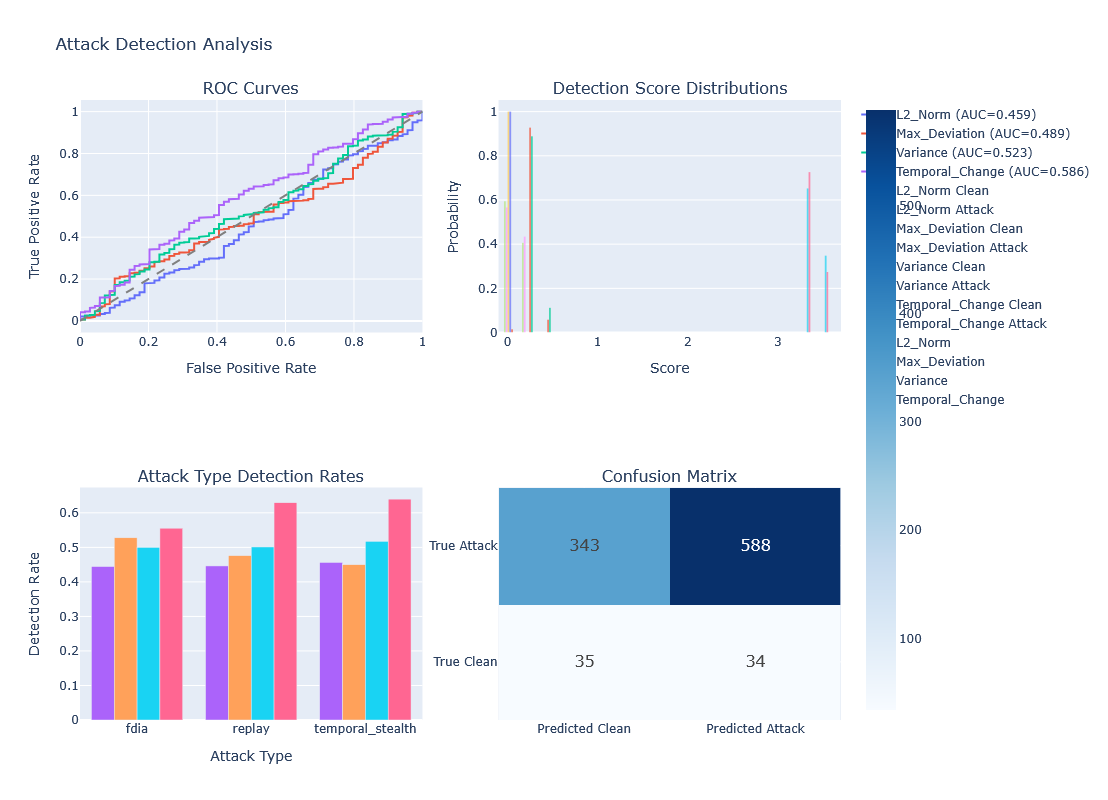

In [6]:
# Analyze detection performance
detection_fig = visualizer.plot_attack_detection_analysis(attack_data)
detection_fig.show()

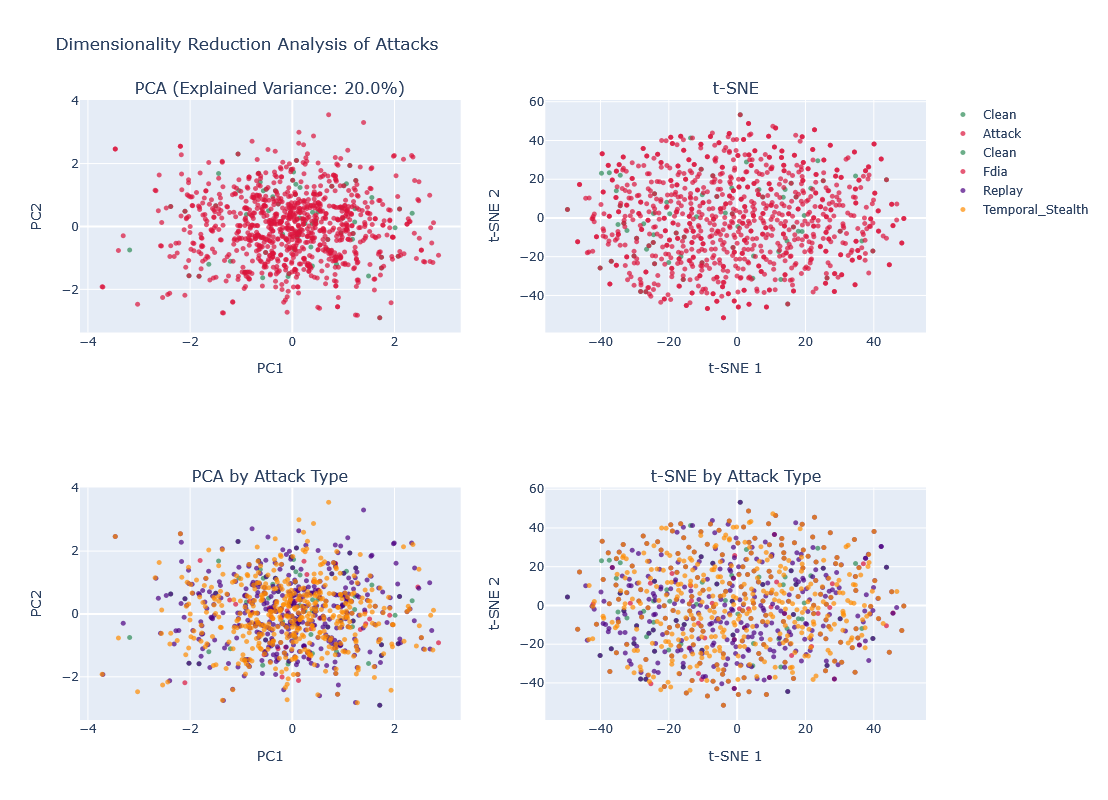

In [7]:
# Visualize attacks in reduced dimensional space
dimensionality_fig = visualizer.plot_attack_dimensionality_analysis(attack_data)
dimensionality_fig.show()

## 3. Time Series Analysis

In [9]:
# Real-time attack simulation
import time
from IPython.display import clear_output

def simulate_realtime_attacks(duration_seconds=30, update_interval=2):
    """Simulate real-time attack detection."""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Initialize data buffers
    window_size = 50
    time_buffer = []
    measurement_buffer = []
    attack_buffer = []
    
    start_time = time.time()
    
    while time.time() - start_time < duration_seconds:
        # Generate new measurement
        current_time = time.time() - start_time
        
        # Base measurement with some variation
        base_value = 1.0 + 0.1 * np.sin(current_time * 0.5)
        noise = np.random.normal(0, 0.02)
        measurement = base_value + noise
        
        # Randomly inject attacks
        is_attack = np.random.random() < 0.2  # 20% attack probability
        if is_attack:
            attack_magnitude = np.random.uniform(0.1, 0.3)
            measurement += attack_magnitude
        
        # Update buffers
        time_buffer.append(current_time)
        measurement_buffer.append(measurement)
        attack_buffer.append(is_attack)
        
        # Keep only recent data
        if len(time_buffer) > window_size:
            time_buffer.pop(0)
            measurement_buffer.pop(0)
            attack_buffer.pop(0)
        
        # Update plots every few iterations
        if len(time_buffer) % 5 == 0:
            clear_output(wait=True)
            
            # Plot 1: Time series
            ax1.clear()
            colors = ['green' if not att else 'red' for att in attack_buffer]
            ax1.scatter(time_buffer, measurement_buffer, c=colors, alpha=0.7)
            ax1.plot(time_buffer, measurement_buffer, 'b-', alpha=0.3)
            ax1.set_title('Real-time Measurement Stream')
            ax1.set_ylabel('Measurement Value')
            ax1.grid(True)
            
            # Plot 2: Attack detection rate
            ax2.clear()
            if len(attack_buffer) >= 10:
                attack_rate = np.convolve(attack_buffer, np.ones(10)/10, mode='valid')
                ax2.plot(time_buffer[9:], attack_rate, 'r-', linewidth=2)
                ax2.set_title('Attack Detection Rate (10-sample window)')
                ax2.set_ylabel('Attack Rate')
                ax2.set_xlabel('Time (seconds)')
                ax2.set_ylim(0, 1)
                ax2.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        time.sleep(update_interval / 10)  # Small delay
    
    print("\nReal-time simulation completed!")
    total_attacks = sum(attack_buffer)
    print(f"Total attacks detected: {total_attacks}/{len(attack_buffer)} ({total_attacks/len(attack_buffer)*100:.1f}%)")

# Run simulation (uncomment to run)
simulate_realtime_attacks(duration_seconds=20)
print("Note: Uncomment the line above to run real-time attack simulation")

<Figure size 800x550 with 0 Axes>


Real-time simulation completed!
Total attacks detected: 9/50 (18.0%)
Note: Uncomment the line above to run real-time attack simulation


In [10]:
# Save attack data for future use
output_dir = '../outputs/experiments'
os.makedirs(output_dir, exist_ok=True)

# Save attack dataset
generator.save_attack_dataset(
    attack_data, 
    '../outputs', 
    'notebook_demo_attacks'
)

# Save individual plots
plot_dir = '../outputs/reports/individual_plots'
os.makedirs(plot_dir, exist_ok=True)

# Save figures if they exist
try:
    overview_fig.write_html(f'{plot_dir}/attack_overview.html')
    print(f"Saved: attack_overview.html")
except NameError:
    print("Skipped: overview_fig not defined")

try:
    timeseries_fig.write_html(f'{plot_dir}/attack_timeseries.html')
    print(f"Saved: attack_timeseries.html")
except NameError:
    print("Skipped: timeseries_fig not defined")

try:
    detection_fig.write_html(f'{plot_dir}/attack_detection.html')
    print(f"Saved: attack_detection.html")
except NameError:
    print("Skipped: detection_fig not defined")

try:
    dimensionality_fig.write_html(f'{plot_dir}/attack_dimensionality.html')
    print(f"Saved: attack_dimensionality.html")
except NameError:
    print("Skipped: dimensionality_fig not defined")

print("\nResults saved:")
print(f"- Attack dataset: ../outputs/experiments/notebook_demo_attacks_attacks.npz")
print(f"- Individual plots: {plot_dir}/")
print(f"- Interactive dashboard: ../outputs/reports/attack_dashboard.html")

Saved: attack_overview.html
Saved: attack_timeseries.html
Saved: attack_detection.html
Saved: attack_dimensionality.html

Results saved:
- Attack dataset: ../outputs/experiments/notebook_demo_attacks_attacks.npz
- Individual plots: ../outputs/reports/individual_plots/
- Interactive dashboard: ../outputs/reports/attack_dashboard.html


In [11]:
# Analyze detection performance
detection_fig = visualizer.plot_attack_detection_analysis(attack_data)
detection_fig.show()

## 5. Dimensionality Reduction Analysis

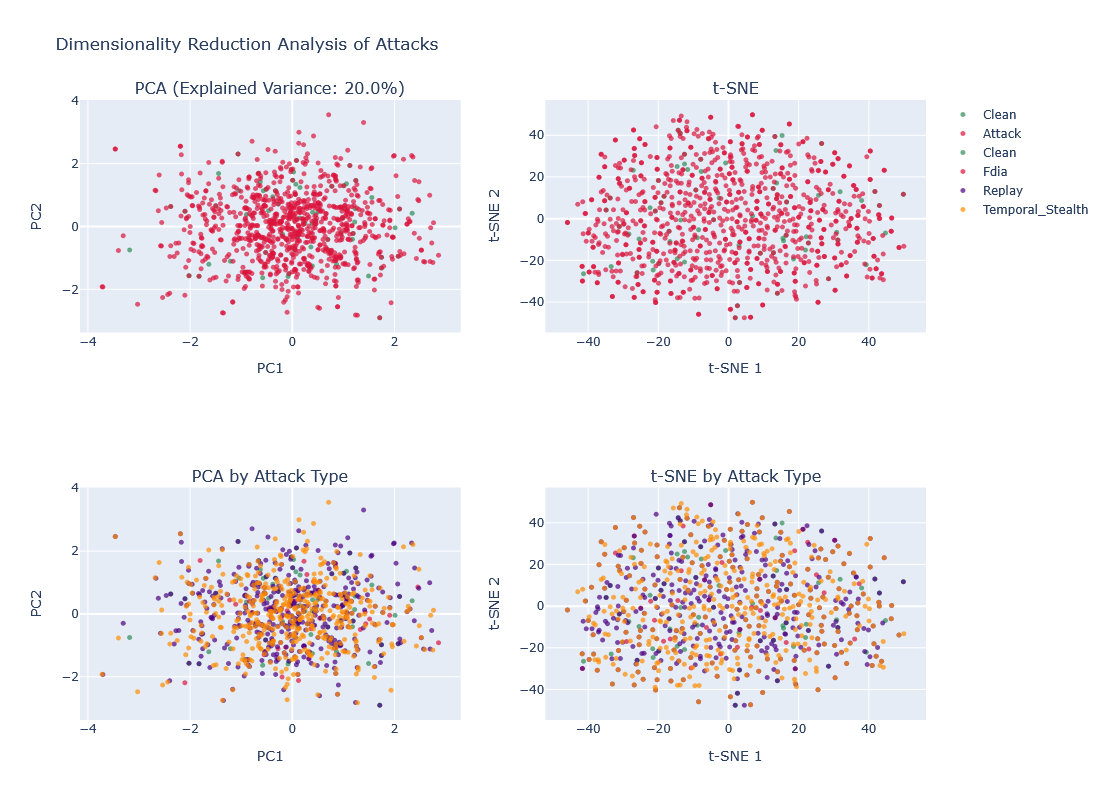

In [12]:
# Visualize attacks in reduced dimensional space
dimensionality_fig = visualizer.plot_attack_dimensionality_analysis(attack_data)
dimensionality_fig.show()

## 6. Interactive Dashboard

Create a comprehensive interactive dashboard combining all visualizations.

In [13]:
# Create interactive dashboard
dashboard_path = visualizer.create_interactive_dashboard(
    attack_data,
    save_path='../outputs/reports/attack_dashboard.html'
)

print(f"📊 Interactive dashboard created: {dashboard_path}")
print("Open this file in your web browser for full interactive experience.")

# Display link
from IPython.display import HTML
HTML(f'<a href="{dashboard_path}" target="_blank">🔗 Open Dashboard</a>')

📊 Interactive dashboard created: ../outputs/reports/attack_dashboard.html
Open this file in your web browser for full interactive experience.


## 7. Custom Attack Analysis

Analyze specific attack types in detail.

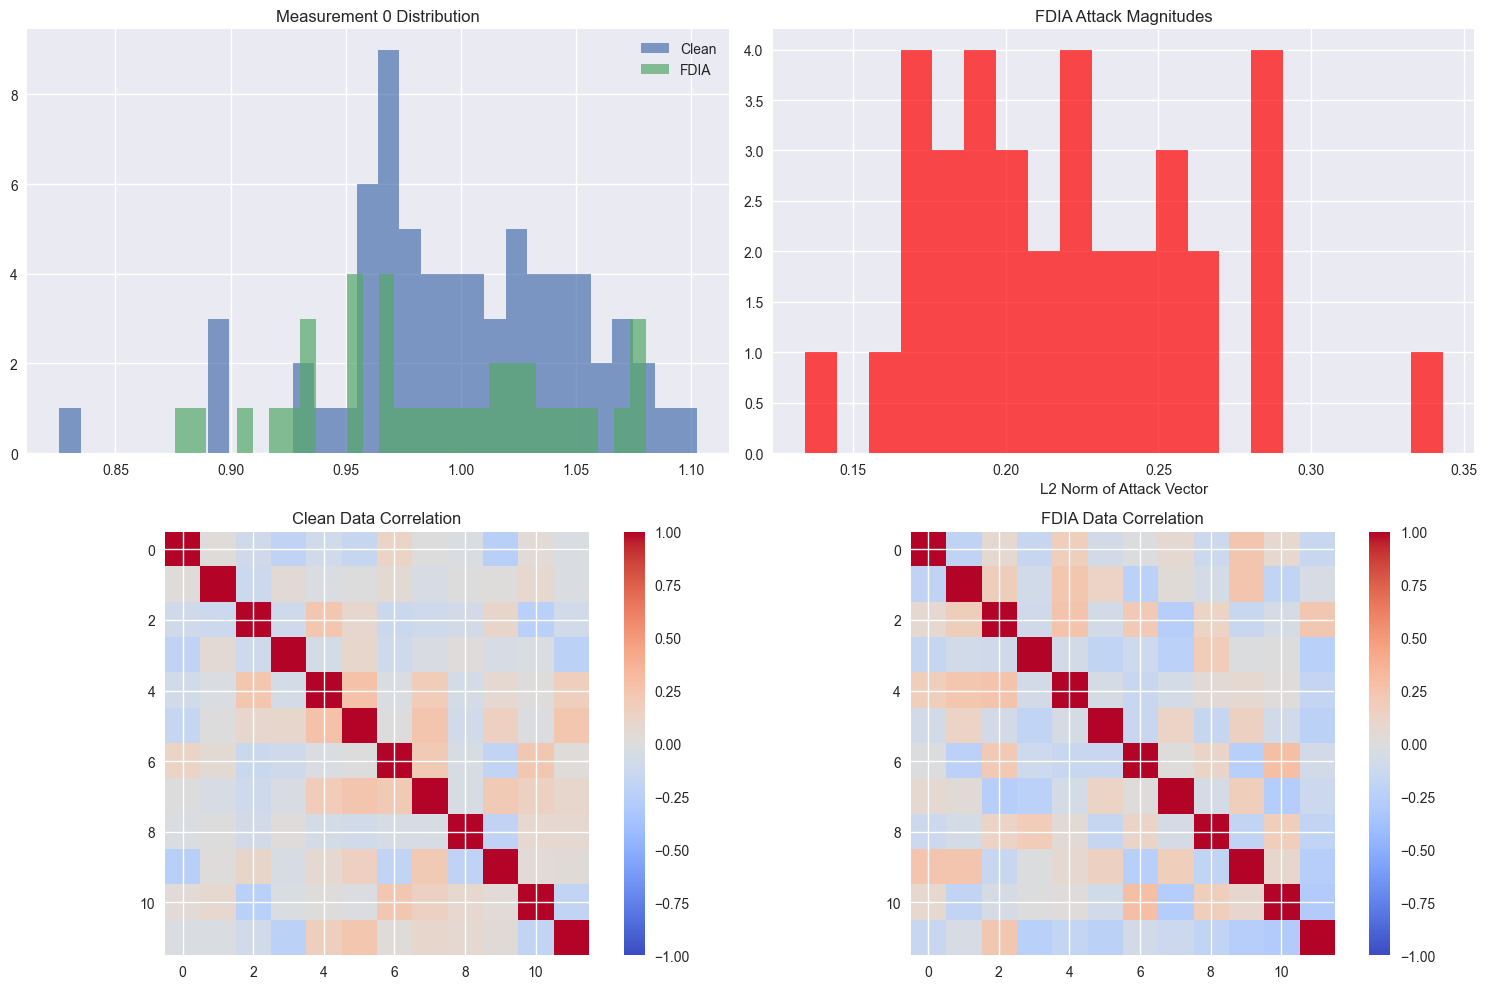

FDIA Analysis:
- Number of FDIA attacks: 36
- Mean attack magnitude: 0.2210
- Max attack magnitude: 0.3430


In [14]:
# Analyze FDIA attacks specifically
measurements = attack_data['clean']
labels = attack_data['labels']
attack_types = attack_data['attack_types']

# Extract FDIA attacks
fdia_mask = (labels == 1) & (attack_types == 'fdia')
fdia_measurements = measurements[fdia_mask]
clean_measurements = measurements[labels == 0]

if len(fdia_measurements) > 0:
    # Compare distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Measurement distributions
    axes[0,0].hist(clean_measurements[:, 0], alpha=0.7, label='Clean', bins=30)
    axes[0,0].hist(fdia_measurements[:, 0], alpha=0.7, label='FDIA', bins=30)
    axes[0,0].set_title('Measurement 0 Distribution')
    axes[0,0].legend()
    
    # Attack magnitude distribution
    if len(fdia_measurements) <= len(clean_measurements):
        attack_magnitudes = np.linalg.norm(
            fdia_measurements - clean_measurements[:len(fdia_measurements)], axis=1
        )
        axes[0,1].hist(attack_magnitudes, bins=20, alpha=0.7, color='red')
        axes[0,1].set_title('FDIA Attack Magnitudes')
        axes[0,1].set_xlabel('L2 Norm of Attack Vector')
    
    # Correlation analysis
    clean_corr = np.corrcoef(clean_measurements[:100].T)
    im1 = axes[1,0].imshow(clean_corr, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1,0].set_title('Clean Data Correlation')
    plt.colorbar(im1, ax=axes[1,0])
    
    if len(fdia_measurements) >= 10:
        fdia_corr = np.corrcoef(fdia_measurements[:min(100, len(fdia_measurements))].T)
        im2 = axes[1,1].imshow(fdia_corr, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1,1].set_title('FDIA Data Correlation')
        plt.colorbar(im2, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"FDIA Analysis:")
    print(f"- Number of FDIA attacks: {len(fdia_measurements)}")
    if len(attack_magnitudes) > 0:
        print(f"- Mean attack magnitude: {np.mean(attack_magnitudes):.4f}")
        print(f"- Max attack magnitude: {np.max(attack_magnitudes):.4f}")
else:
    print("No FDIA attacks found in the dataset.")

## 8. Real-time Attack Simulation

Simulate and visualize attacks in real-time.

In [15]:
# Real-time attack simulation
import time
from IPython.display import clear_output

def simulate_realtime_attacks(duration_seconds=30, update_interval=2):
    """Simulate real-time attack detection."""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Initialize data buffers
    window_size = 50
    time_buffer = []
    measurement_buffer = []
    attack_buffer = []
    
    start_time = time.time()
    
    while time.time() - start_time < duration_seconds:
        # Generate new measurement
        current_time = time.time() - start_time
        
        # Base measurement with some variation
        base_value = 1.0 + 0.1 * np.sin(current_time * 0.5)
        noise = np.random.normal(0, 0.02)
        measurement = base_value + noise
        
        # Randomly inject attacks
        is_attack = np.random.random() < 0.2  # 20% attack probability
        if is_attack:
            attack_magnitude = np.random.uniform(0.1, 0.3)
            measurement += attack_magnitude
        
        # Update buffers
        time_buffer.append(current_time)
        measurement_buffer.append(measurement)
        attack_buffer.append(is_attack)
        
        # Keep only recent data
        if len(time_buffer) > window_size:
            time_buffer.pop(0)
            measurement_buffer.pop(0)
            attack_buffer.pop(0)
        
        # Update plots every few iterations
        if len(time_buffer) % 5 == 0:
            clear_output(wait=True)
            
            # Plot 1: Time series
            ax1.clear()
            colors = ['green' if not att else 'red' for att in attack_buffer]
            ax1.scatter(time_buffer, measurement_buffer, c=colors, alpha=0.7)
            ax1.plot(time_buffer, measurement_buffer, 'b-', alpha=0.3)
            ax1.set_title('Real-time Measurement Stream')
            ax1.set_ylabel('Measurement Value')
            ax1.grid(True)
            
            # Plot 2: Attack detection rate
            ax2.clear()
            if len(attack_buffer) >= 10:
                attack_rate = np.convolve(attack_buffer, np.ones(10)/10, mode='valid')
                ax2.plot(time_buffer[9:], attack_rate, 'r-', linewidth=2)
                ax2.set_title('Attack Detection Rate (10-sample window)')
                ax2.set_ylabel('Attack Rate')
                ax2.set_xlabel('Time (seconds)')
                ax2.set_ylim(0, 1)
                ax2.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        time.sleep(update_interval / 10)  # Small delay
    
    print("\n✅ Real-time simulation completed!")
    total_attacks = sum(attack_buffer)
    print(f"Total attacks detected: {total_attacks}/{len(attack_buffer)} ({total_attacks/len(attack_buffer)*100:.1f}%)")

# Run simulation (uncomment to run)
# simulate_realtime_attacks(duration_seconds=20)
print("💡 Uncomment the line above to run real-time attack simulation")

💡 Uncomment the line above to run real-time attack simulation


## 9. Export Results

Save all visualizations and analysis results.

In [16]:
# Save attack data for future use
output_dir = '../outputs/experiments'
os.makedirs(output_dir, exist_ok=True)

# Save attack dataset
generator.save_attack_dataset(
    attack_data, 
    '../outputs', 
    'notebook_demo_attacks'
)

# Save individual plots
plot_dir = '../outputs/reports/individual_plots'
os.makedirs(plot_dir, exist_ok=True)

overview_fig.write_html(f'{plot_dir}/attack_overview.html')
timeseries_fig.write_html(f'{plot_dir}/attack_timeseries.html')
detection_fig.write_html(f'{plot_dir}/attack_detection.html')
dimensionality_fig.write_html(f'{plot_dir}/attack_dimensionality.html')

print("📁 Results saved:")
print(f"- Attack dataset: ../outputs/experiments/notebook_demo_attacks_attacks.npz")
print(f"- Individual plots: {plot_dir}/")
print(f"- Interactive dashboard: ../outputs/reports/attack_dashboard.html")

📁 Results saved:
- Attack dataset: ../outputs/experiments/notebook_demo_attacks_attacks.npz
- Individual plots: ../outputs/reports/individual_plots/
- Interactive dashboard: ../outputs/reports/attack_dashboard.html


## Summary

This notebook demonstrated:

1. **Attack Data Generation**: Created synthetic attack datasets with multiple attack types
2. **Comprehensive Visualization**: Multiple interactive plots showing attack patterns
3. **Detection Analysis**: ROC curves and detection performance metrics
4. **Dimensionality Analysis**: PCA and t-SNE visualization of attack clusters
5. **Real-time Simulation**: Live attack detection simulation
6. **Interactive Dashboard**: Combined all visualizations into a single dashboard

### Next Steps:
- Use real data from the digital-twin-dataset API
- Train actual ML models for detection
- Implement advanced attack types
- Develop real-time detection systems

### Key Files Generated:
- `attack_dashboard.html`: Interactive dashboard
- `notebook_demo_attacks_attacks.npz`: Attack dataset
- Individual plot HTML files for sharing